## 🦜🔗 Conversational Agent und Memory

### Short term memory


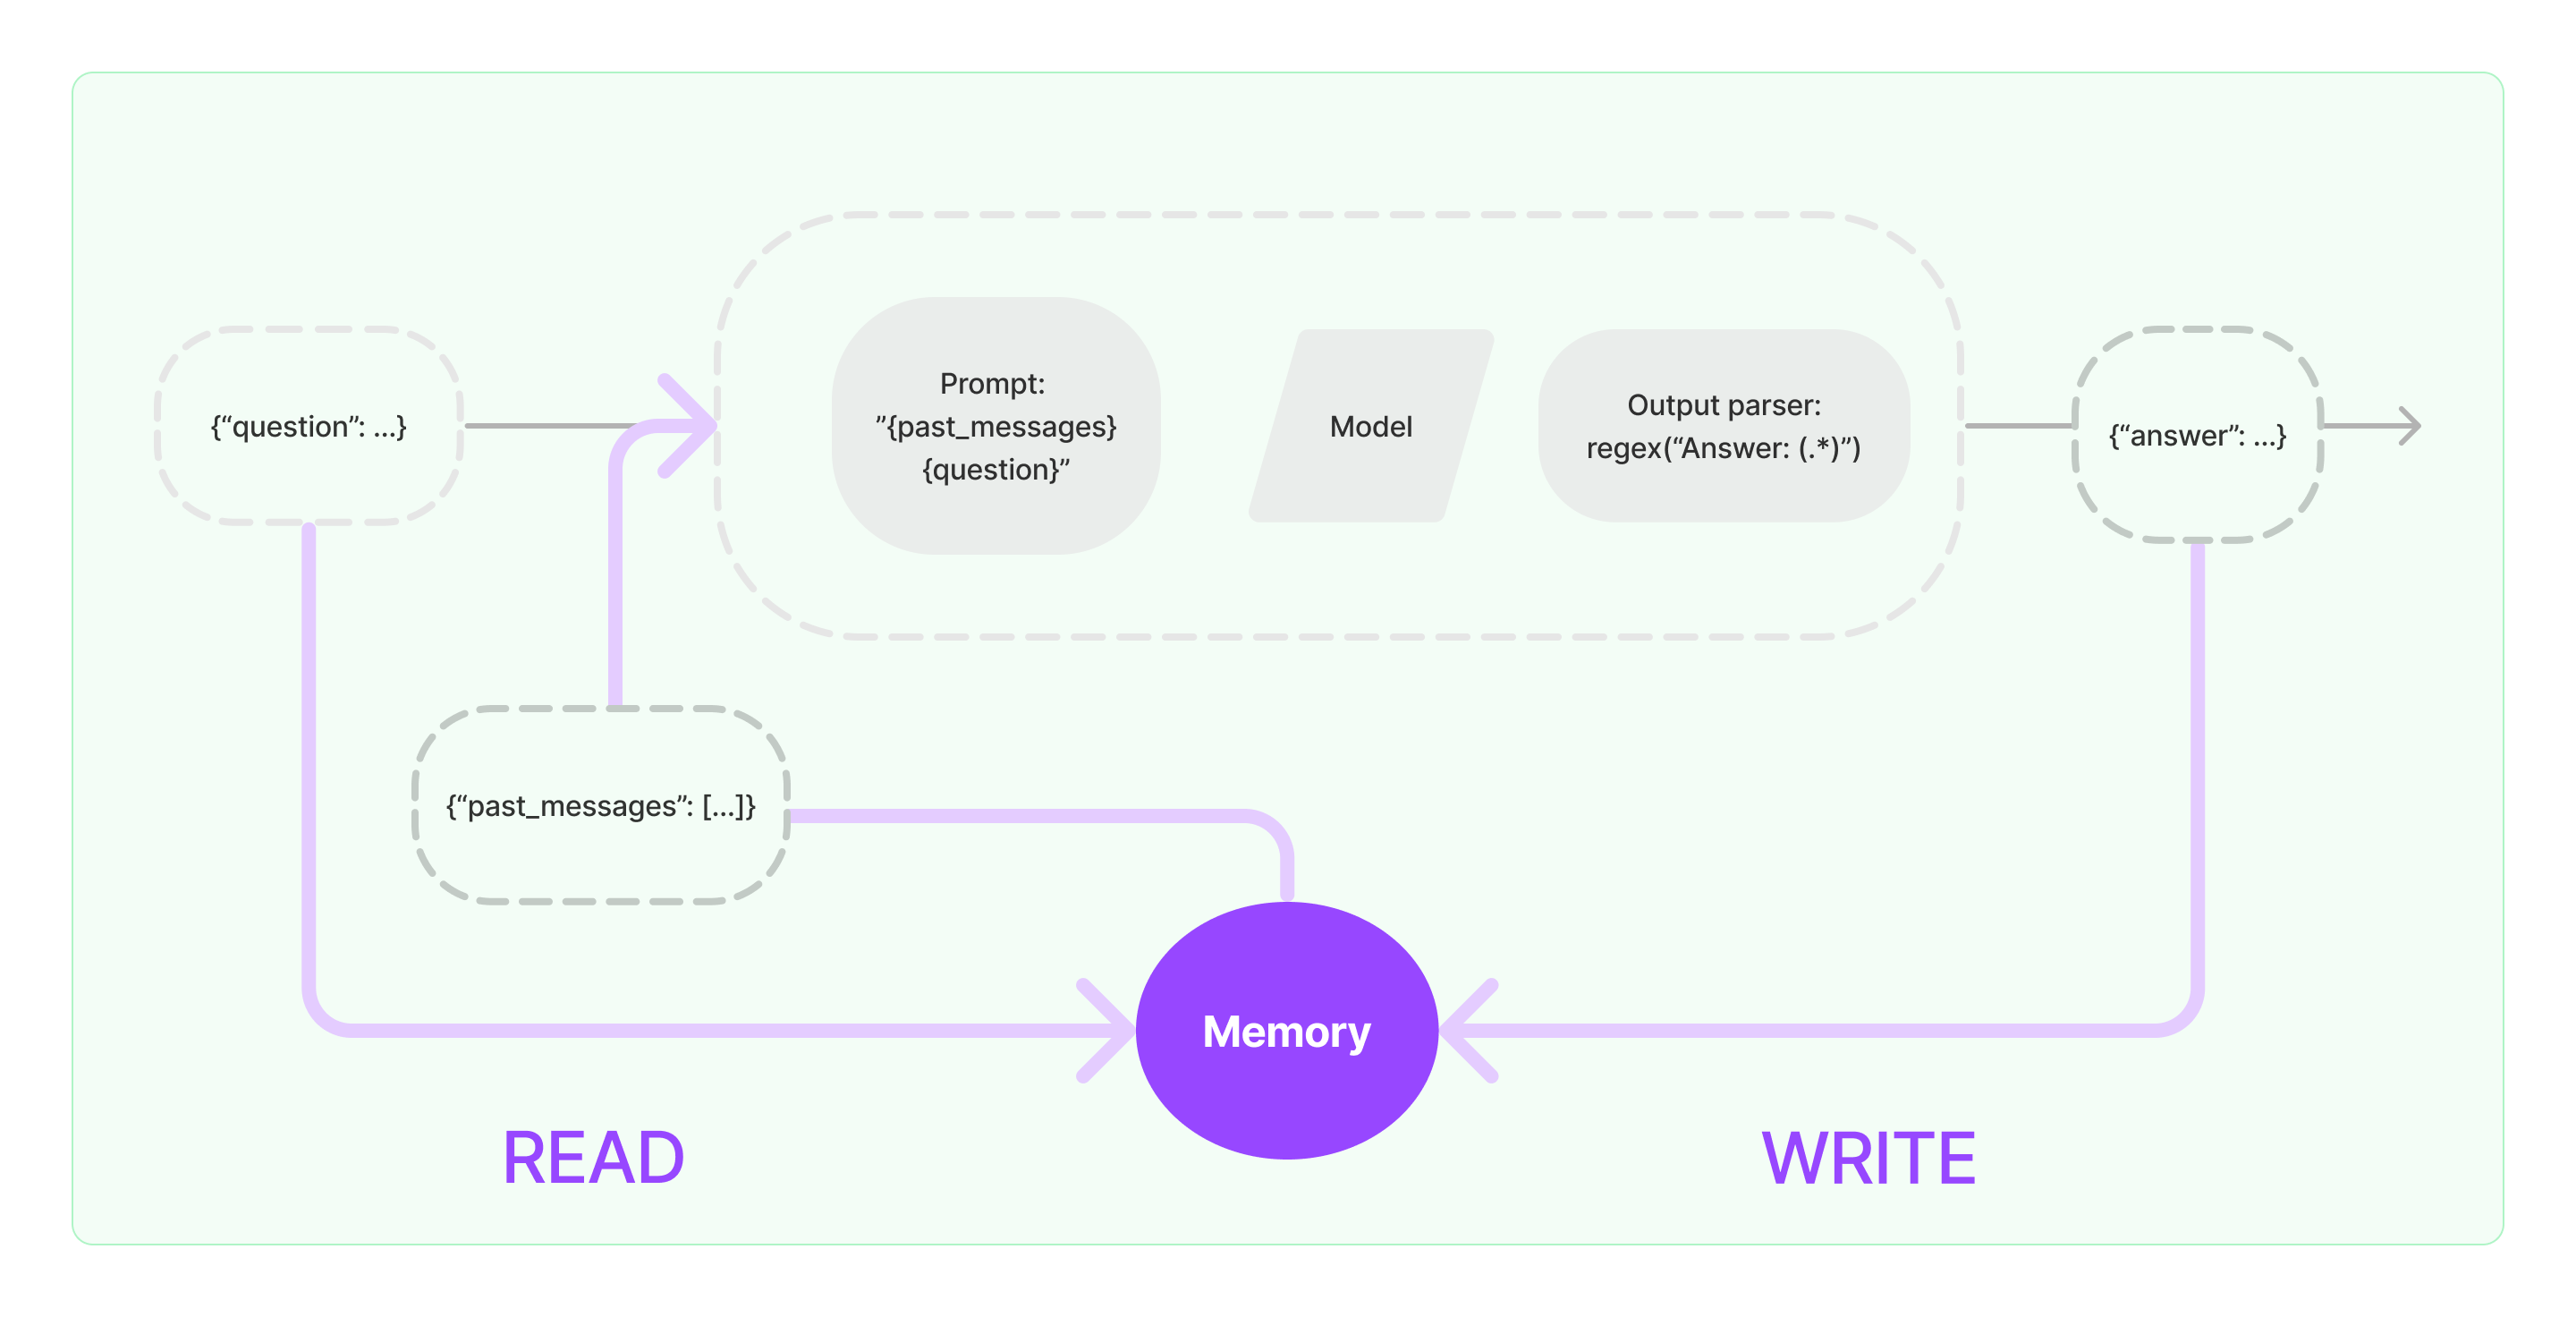


Für Chatbots, die eine fortlaufende Konversation führen sollen, braucht man irgendwie eine Historie. Die Grundidee ist ganz einfach. Direkt nach der Nutzereingabe wird die bisherige Chathistorie mit ins Prompt eingefügt, damit ist das LLM bestens informiert. Nach der Ausgabe des LLM wird diese Ausgabe und die Nutzereingabe als zwei weitere Messages an die Historie angefügt.

Diese simple Idee hat aber einen Haken. Man hat keine unendlich lange Kontextlänge, die man dem LLM geben kann. Auch wenn die Kontextlänge immer größer wird - Gemini hat rund 1.000.000 Token(!) - kosten Inputtoken auch Geld (Eine vollgeschriebene A4-Seite kostet auf gpt4 ca 1 cent).

Wie handhabe ich einen Chatverlauf, wenn die Historie immer größer wird? Auf der LangChain Doku zu [Memory](https://python.langchain.com/docs/modules/memory/types/) findet man dazu einige Ansätze. Ein komplexes Memory-System wird man aber vermutlich eher später im Development bauen, wenn es sich als nötig erweist.

#### Wir probieren das ConversationBufferWindowMemory aus


In [2]:
from langchain.memory import ConversationBufferWindowMemory
from langchain.chains.conversation.base import ConversationChain
from helpers import llm

# Setze k=2. Damit werden die letzten beiden Nachrichtenpaare gespeichert.
chain_app = ConversationChain(
    llm=llm(), memory=ConversationBufferWindowMemory(k=2), verbose=False
)

/var/folders/01/ywnzdvn56c16b5vdy9c7_q8w0000gn/T/ipykernel_20055/1751200026.py:6: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use RunnableWithMessageHistory: https://python.langchain.com/v0.2/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html instead.
  chain_app = ConversationChain(


#### Jetzt hat unser LLM ein Gedächtnis. Wir können chatten.


In [3]:
from helpers import interactive_conversation

interactive_conversation(chain_app)

Byebye


#### Memory für den Graphen als Checkpoint ist schon bekannt

Langgraph bietet für Memory Checkpoints an. Alle Zwischenergebnisse werden in Checkpoints geschrieben. Wir bauen uns den kleinstmöglichen Graphen (Nur eine Node) und geben ihm einen In-Memory Checkpointer.

Aktuell sind verfeinerte Memory-Lösungen wie das ConversationBufferWindowMemory für LangGraph noch nicht "out-of-the-box" verfügbar.

Wir bauen erst einmal einen Chatbot, der jedes mal die komplette History bekommt und kürzen in einem zweiten Schritt einfach manuell den Verlauf


In [4]:
from langgraph.graph import MessageGraph, END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
model = llm()

simple_chatbot_builder = MessageGraph()
simple_chatbot_builder.add_node("chatbot", model)
simple_chatbot_builder.set_entry_point("chatbot")
simple_chatbot_builder.add_edge("chatbot", END)

simple_chatbot_graph = simple_chatbot_builder.compile(checkpointer=memory)

In [5]:
from helpers import interactive_langgraph_conversation

config = {"configurable": {"thread_id": "1"}}
interactive_langgraph_conversation(simple_chatbot_graph, config)

Byebye


#### Und jetzt nochmal wie versprochen der Chatbot mit verkürzter Historie


In [6]:
from typing import List
from langchain_core.messages import BaseMessage

k = 2


def buffer_window_input_llm(messages: List[BaseMessage]):
    k = 2
    if len(messages) > (1 + k * 2):
        return model.invoke(messages[-(1 + k * 2) :])
    else:
        return model.invoke(messages)


buffer_chatbot_builder = MessageGraph()
buffer_chatbot_builder.add_node("chatbot", buffer_window_input_llm)
buffer_chatbot_builder.set_entry_point("chatbot")
buffer_chatbot_builder.add_edge("chatbot", END)

buffer_window_graph = buffer_chatbot_builder.compile(checkpointer=memory)

In [7]:
config = {"configurable": {"thread_id": "2"}}
interactive_langgraph_conversation(buffer_window_graph, config, k)

Byebye


## Long Term Memory

Long Term Memory ist irgendeine Art von Gesprächsverlauf, der über einen "Thread" hinausgeht.

Long Term Memory ist oft als Vektordatenbank (mit Embeddings) implementiert.

Wir wollen hierzu ein kleines Beispiel bauen:

- Ein Nutzer stellt eine Anfrage an einen integrierten Chatbot
- Der Chatbot sieht in seiner Wissensdatenbank nach, findet aber keine ausreichend gute Antwort
- Daraufhin leitet der Chatbot die Frage an einen Firmenmitarbeiter weiter
- Die Antwort des Mitarbeiters gibt der Chatbot an den Nutzer zurück und speichert sie in ein Long Term Memory, das über die Zeit hinweg eine FAQ-Sammlung wird.
- Falls ein anderer Kunde nochmal eine ähnliche Frage stellt, wird der Chatbot zuerst in der FAQ die Antwort finden und die Firmenmitarbeiter dadurch entlasten

Wie üblich muss der folgende Code absolut nicht komplett verstanden werden. Man kann zu gegebener Zeit davon abkopieren, wenn man sich gemerkt hat, was der Code tut.


#### Den AgentState definieren


In [8]:
from typing import Annotated, Literal, TypedDict, Optional
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    query: str
    last_step: Optional[Literal["initial", "check", "final"]]
    scratchpad: Annotated[List[BaseMessage], add_messages]
    answer: Optional[str] = None

#### Das Retriever Tool bauen

Wir bauen hier exemplarisch eine FAQ-Datenbank für Bonn auf


In [9]:
from langchain_community.vectorstores.faiss import FAISS
from helpers import embeddings
from langchain.agents.agent_toolkits import create_retriever_tool


def qa_pair(question: str, answer: str):
    return f"Question: {question} - Answer: {answer}"


qa_db = FAISS.from_texts(
    [
        qa_pair(
            "Which Restaurant in Bonn has the best pizza?",
            "Ristorante Pipi Langstrumpf. An underrated and not well known place in the center of the city",
        )
    ],
    embeddings(),
)
qa_retriever = qa_db.as_retriever()
qa_retriever_tool = create_retriever_tool(
    qa_retriever,
    "search_bonn_faq",
    "This is the best place to look for any information about Bonn.",
)

#### Das Mitarbeiter-Tool bauen


In [10]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool


@tool
def ask_bonn_employee(query: str):
    """I am an employee of the city of Bonn. I can provide the BEST POSSIBLE help for difficult and uncommon questions about the city."""
    return input(prompt=f"Please answer this question from a user: {query}?")


tools = [qa_retriever_tool, ask_bonn_employee]

#### Super technisches Detail

Langchain bietet einem die Möglichkeit von "configurable_alternatives". Das ist in diesem Fall nützlich.

Ich möchte, dass der Agent:

- beim ersten Durchlauf entweder die Frage beantwortet oder das RAG anstößt
- beim zweiten Durchlauf (nach dem RAG) entweder die Frage beantwortet oder den Mitarbeiter um Rat fragt
- beim dritten Mal muss eine Antwort geliefert werden. Alle Quellen sind erschöpft

Dafür möchte ich dynamisch Tools an meinen Agenten kleben (entweder RAG, Mitarbeiter-Tool oder überhaupt kein tool).


In [11]:
from langchain.prompts import (
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)
from langchain_core.runnables import ConfigurableField

prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            "You are a helpful assistant. Answer this question as good as you can. Original Question:"
        ),
        HumanMessagePromptTemplate.from_template("{query}"),
        MessagesPlaceholder("scratchpad"),
    ]
)
initial_chain = prompt | llm(temperature=0).bind_tools([qa_retriever_tool])
check_chain = prompt | llm(temperature=0).bind_tools([ask_bonn_employee])
final_chain = prompt | llm(temperature=0)
configurable_chain = initial_chain.configurable_alternatives(
    ConfigurableField(id="configurable_chain"),
    default_key="initial",
    check=check_chain,
    final=final_chain,
)

#### Jetzt definiere ich mir meine Knoten und Kanten


In [22]:
from langchain_core.runnables import chain


def agent(state):
    last_step = state.get("last_step", None)
    match last_step:
        case None:
            current_step = "initial"
        case "initial":
            current_step = "check"
        case _:
            current_step = "final"

    result = configurable_chain.with_config(
        configurable={"configurable_chain": current_step}
    ).invoke(
        {
            "query": state["query"],
            "scratchpad": state["scratchpad"] if state["scratchpad"] else [],
        }
    )
    return {"scratchpad": [result], "last_step": current_step}


@chain
def tool_executor(tool_call):
    tool = {tool.name: tool for tool in tools}[tool_call["name"]]
    return ToolMessage(tool.invoke(tool_call["args"]), tool_call_id=tool_call["id"])


def augment(state):
    last_message = state["scratchpad"][-1]
    return {"scratchpad": tool_executor.batch(last_message.tool_calls)}


def augment_or_finish(state):
    last_message = state["scratchpad"][-1]

    if "tool_calls" not in last_message.additional_kwargs:
        return "finish"

    else:
        return "augment"

#### Und ganz zum Schluss den Finish Knoten, der die FAQ anreichern darf


In [23]:
def finish(state):
    answer = state["scratchpad"][-1].content

    if state["last_step"] == "final":
        text = qa_pair(state["query"], answer)
        print("saving QA to db: ", text)
        print("\n --- \n")
        qa_db.add_texts([text])

    return {"answer": answer}

#### Kompilieren


In [24]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState)
workflow.add_node("agent", agent)
workflow.add_node("augment", augment)
workflow.add_node("finish", finish)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    augment_or_finish,
    {
        "augment": "augment",
        "finish": "finish",
    },
)
workflow.add_edge("augment", "agent")
workflow.add_edge("finish", END)

long_term_memory_graph = (
    workflow.compile()
)  # Kompilieren ohne Checkpoint, also ohne short-term memory

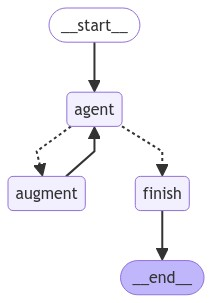

In [25]:
from IPython.display import Image

Image(long_term_memory_graph.get_graph().draw_mermaid_png())

Los gehts!


In [26]:
for chunk in long_term_memory_graph.stream(
    {"query": "Where do i get the best pizza in Bonn?"}
):
    for k, v in chunk.items():
        if k != "__end__":
            print(f"result from node: {k}")
            print(v)
            print("\n --- \n")

result from node: agent
{'last_step': 'initial', 'scratchpad': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_OJnCc47dQLhrOsHKjIDGb0v0', 'function': {'arguments': '{"query":"best pizza in Bonn"}', 'name': 'search_bonn_faq'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e'}, id='run-246f256b-dffd-4909-8822-768742ec5a0c-0', tool_calls=[{'name': 'search_bonn_faq', 'args': {'query': 'best pizza in Bonn'}, 'id': 'call_OJnCc47dQLhrOsHKjIDGb0v0', 'type': 'tool_call'}])]}

 --- 

result from node: augment
{'scratchpad': [ToolMessage(content='Question: Which Restaurant in Bonn has the best pizza? - Answer: Ristorante Pipi Langstrumpf. An underrated and not well known place in the center of the city', tool_call_id='call_OJnCc47dQLhrOsHKjIDGb0v0')]}

 --- 

result from node: agent
{'last_step': 'check', 'scratchpad': [AIMessage(content='The best pizza in Bonn c

Das wusste er schon. Das war unser einziges QA-Paar in der FAQ Datenbank. Fragen wir ihn was neues:


In [27]:
for chunk in long_term_memory_graph.stream(
    {"query": "Why are there yellow balloons hanging from the city hall of Bonn?"}
):
    for k, v in chunk.items():
        if k != "__end__":
            print(f"result from node: {k}")
            print(v)
            print("\n --- \n")

result from node: agent
{'last_step': 'initial', 'scratchpad': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_LK3cnDjEjVRY2bAyLQolptsn', 'function': {'arguments': '{"query":"yellow balloons city hall Bonn"}', 'name': 'search_bonn_faq'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e'}, id='run-542c39ea-e375-4128-9d89-037cb5f7ea71-0', tool_calls=[{'name': 'search_bonn_faq', 'args': {'query': 'yellow balloons city hall Bonn'}, 'id': 'call_LK3cnDjEjVRY2bAyLQolptsn', 'type': 'tool_call'}])]}

 --- 

result from node: augment
{'scratchpad': [ToolMessage(content='Question: Which Restaurant in Bonn has the best pizza? - Answer: Ristorante Pipi Langstrumpf. An underrated and not well known place in the center of the city', tool_call_id='call_LK3cnDjEjVRY2bAyLQolptsn')]}

 --- 

result from node: agent
{'last_step': 'check', 'scratchpad': [AIMessage(content='

Hat er das jetzt im Long Term Memory? Hier ist kein Checkpoint oder sowas drin. Das ist eine **echte** Vektordatenbank


In [28]:
for chunk in long_term_memory_graph.stream(
    {
        "query": "What is the purpose of the yellow stuff hanging from the Bonn city hall right now?"
    }
):
    for k, v in chunk.items():
        if k != "__end__":
            print(f"result from node: {k}")
            print(v)
            print("\n --- \n")

result from node: agent
{'last_step': 'initial', 'scratchpad': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ziCekOuTW7JWOtg13OdbDxHO', 'function': {'arguments': '{"query":"yellow stuff hanging from Bonn city hall"}', 'name': 'search_bonn_faq'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f33667828e'}, id='run-e7ec6e73-0599-4b47-8c0a-88b47771a1fb-0', tool_calls=[{'name': 'search_bonn_faq', 'args': {'query': 'yellow stuff hanging from Bonn city hall'}, 'id': 'call_ziCekOuTW7JWOtg13OdbDxHO', 'type': 'tool_call'}])]}

 --- 

result from node: augment
{'scratchpad': [ToolMessage(content='Question: Why are there yellow balloons hanging from the city hall of Bonn? - Answer: The yellow balloons hanging from the city hall of Bonn are there to celebrate the birthday of the mayor.\n\nQuestion: Which Restaurant in Bonn has the best pizza? - Answer: Ristorante Pipi Lan

## ✅ Aufgabe

### Short term memory

Erstellt einen Agenten mit einem SQLite in-memory Checkpointer und schaut euch das Config-Objekt an.
Erstellt ein neues Config-Objekt mit einer anderen Thread-ID und überprüft, dass die Chathistorien der beiden Threads sich nicht mischen.


In [ ]:
# from langgraph.checkpoint.
# sqlite_memory =

sqlite_chatbot_graph = simple_chatbot_builder.compile(checkpointer=sqlite_memory)

In [ ]:
config_thread_droelf = {"configurable": {"thread_id": "103"}}
interactive_langgraph_conversation(sqlite_chatbot_graph, config_thread_droelf)

In [ ]:
# config_thread_noelf =
interactive_langgraph_conversation(sqlite_chatbot_graph, config_thread_noelf)

### Long term memory

Stellt dem Mitarbeiter der Stadt Bonn noch eine exotische Frage und beantwortet sie dann selbst.


In [ ]:
for chunk in long_term_memory_graph.stream({"query": "YOUR CREATIVE QUERY GOES HERE"}):
    for k, v in chunk.items():
        if k != "__end__":
            print(f"result from node: {k}")
            print(v)
            print("\n --- \n")